# Treinamento usando funções Pytorch

Vamos substituir algumas funções que fizemos no notebook do módulo 1 por funções do Pytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

data = torch.from_numpy(np.loadtxt('../data/age_data_3.txt')).to(torch.float32)
inputs, targets = data.T

### Camada Linear no PyTorch

A camada linear no PyTorch, também conhecida como `torch.nn.Linear`, é uma das componentes fundamentais em redes neurais, especialmente em modelos que processam dados estruturados ou são parte de uma rede neural mais complexa. Esta camada é usada para realizar uma transformação linear nos dados de entrada, o que é uma etapa essencial em muitos tipos de aprendizado de máquina.

#### Estrutura e Funcionamento

A camada linear realiza a operação matemática conhecida como transformação afim, que pode ser representada pela equação:

$ \text{saida} = xA^T + b $

onde:
- $( x )$ é o tensor de entrada.
- $( A )$ é a matriz de pesos (`weight`), correspondendo ao coeficiente $( a )$ em um modelo linear simples.
- $( b )$ é o vetor de viés (`bias`), similar ao intercepto $( b )$ em regressões lineares.

#### Atributos

- **`.weight`**: Este atributo armazena os pesos da camada, que são aprendidos durante o processo de treinamento. Os pesos são inicializados aleatoriamente e ajustados através de algoritmos de otimização, como o gradiente descendente, para minimizar a função de perda do modelo.

- **`.bias`**: O viés permite que o modelo ajuste a saída independentemente da entrada, oferecendo uma flexibilidade adicional ao definir a função que mapeia as entradas para as saídas. Assim como os pesos, o viés é aprendido durante o treinamento.

In [2]:
model = nn.Linear(in_features=1, out_features=1, bias=True)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[0.1054]], requires_grad=True)
Parameter containing:
tensor([0.8602], requires_grad=True)


### Estruturação de Entradas no PyTorch

No PyTorch, os modelos geralmente esperam que os dados de entrada sejam fornecidos em um formato tensorial específico. Este formato é essencial para garantir o correto processamento dos dados pela rede neural, especialmente quando se lida com diferentes tipos de dados, como imagens ou séries temporais.

#### Formato dos Tensore de Entrada

Para a maioria dos modelos em PyTorch, o tensor de entrada deve seguir a estrutura:

- **NxC1xC2...**, onde:
  - **N** representa o número de instâncias (ou exemplos) que serão processadas em um lote.
  - **C1, C2, ...** são as dimensões dos dados.

#### Exemplo Comum: Imagens

- Para imagens, o formato comum é **NxHxW**:
  - **H** é a altura da imagem (número de linhas).
  - **W** é a largura da imagem (número de colunas).

In [3]:
#Modelos do Pytorch sempre esperam um tensor com tamanho NxC1xC2..., onde N é o número
#de instâncias que serão processadas e C1, C2, ... é a dimensão dos dados.
#Para imagens, os dados terão tamanho NxHxW, onde H é o número de linhas e W o número 
#de colunas das imagens. Mas nos dados deste notebook, cada instância possui um único 
#atributo (altura):
#                     dimensão Nx1
inputs = inputs.reshape(len(inputs),1)
targets = targets.reshape(len(targets),1)

res = model(inputs)
# imprime os 10 primeiros resultados
print(res[:10])
# O código acima faz a seguinte operação:
res_comp = model.weight*inputs + model.bias
print(res_comp[:10])

tensor([[1.0056],
        [0.9908],
        [0.9971],
        [1.0098],
        [1.0066],
        [0.9761],
        [0.9971],
        [0.9845],
        [0.9856],
        [0.9908]], grad_fn=<SliceBackward0>)
tensor([[1.0056],
        [0.9908],
        [0.9971],
        [1.0098],
        [1.0066],
        [0.9761],
        [0.9971],
        [0.9845],
        [0.9856],
        [0.9908]], grad_fn=<SliceBackward0>)


### Treinamento usando funções do Pytorch

O treinamento de um modelo no PyTorch envolve várias etapas fundamentais que permitem ao modelo aprender a partir dos dados fornecidos. Este processo é implementado na função train, que ajusta os parâmetros do modelo usando o `gradiente descendente estocástico (SGD)` e a função de perda de `entropia cruzada binária (BCEWithLogitsLoss)`.

### Entropia Cruzada Binária com Logits

A função de perda `BCEWithLogitsLoss` do PyTorch é projetada especificamente para abordar problemas de classificação binária. Esta função é uma combinação integrada de uma camada sigmoide e a computação de entropia cruzada. A vantagem de combinar esses dois componentes numa única função de perda é dupla:

1. **Estabilidade Numérica:** A combinação direta dos logits (saídas do modelo antes da aplicação da função sigmoide) com a entropia cruzada melhora a estabilidade numérica do cálculo. Isso ocorre porque a função sigmoide pode levar a problemas numéricos quando seus argumentos são muito grandes ou muito pequenos, potencialmente resultando em gradientes que são muito grandes ou muito pequenos para processar de forma eficaz. A implementação de `BCEWithLogitsLoss` lida com isso internamente, evitando cálculos diretos com a função sigmoide que poderiam resultar em overflow ou underflow.

2. **Eficiência de Cálculo:** Ao evitar cálculos redundantes, esta abordagem é computacionalmente mais eficiente. A função sigmoide e a entropia cruzada são combinadas de tal forma que apenas uma passagem é necessária para calcular ambas as operações, o que reduz a carga computacional.

A função calcula a perda da seguinte maneira: para cada par de entrada prevista (logit) e rótulo verdadeiro, aplica a função sigmoide ao logit para obter a probabilidade prevista $( p )$, e então computa a perda de entropia cruzada entre $( p )$ e o rótulo verdadeiro $( y )$ usando a fórmula:

$$ \text{loss} = -\left[ y \cdot \log(p) + (1 - y) \cdot \log(1 - p) \right] $$

### Otimizador SGD (Descida do Gradiente Estocástico)

O Otimizador SGD (`torch.optim.SGD`) é um dos algoritmos mais comuns e fundamentais para a otimização de parâmetros em redes neurais. No contexto do PyTorch, este otimizador é implementado para atualizar os parâmetros de forma iterativa com base no gradiente da função de perda:

- **Cálculo do Gradiente:** O gradiente é calculado usando a retropropagação (backpropagation). Esse gradiente representa a direção na qual a função de perda aumenta mais rapidamente. Para minimizar a perda, precisamos mover os parâmetros na direção oposta ao gradiente.

- **Atualização dos Parâmetros:** A cada iteração de treinamento, o otimizador ajusta os parâmetros subtraindo um produto do gradiente e da taxa de aprendizado (α ou `lr`):

  $$ \beta_j \leftarrow \beta_j - \alpha \frac{\partial}{\partial \beta_j} \text{Loss} $$

- **Taxa de Aprendizado (Learning Rate, `lr`):** Este hiperparâmetro é crucial porque define o tamanho dos passos que o modelo faz na direção oposta ao gradiente. Uma taxa de aprendizado muito alta pode fazer com que o modelo "salte" sobre o mínimo da função de perda, enquanto uma taxa muito baixa pode resultar em uma convergência muito lenta, consumindo recursos computacionais e tempo.

A eficácia do SGD pode ser melhorada com técnicas como o momento (que suaviza a atualização dos parâmetros ao longo do tempo, adicionando uma fração do gradiente de atualização anterior à atualização atual) e a taxa de aprendizado adaptativa (que ajusta a taxa de aprendizado ao longo do tempo para cada parâmetro, acelerando o treinamento e melhorando a performance do modelo).

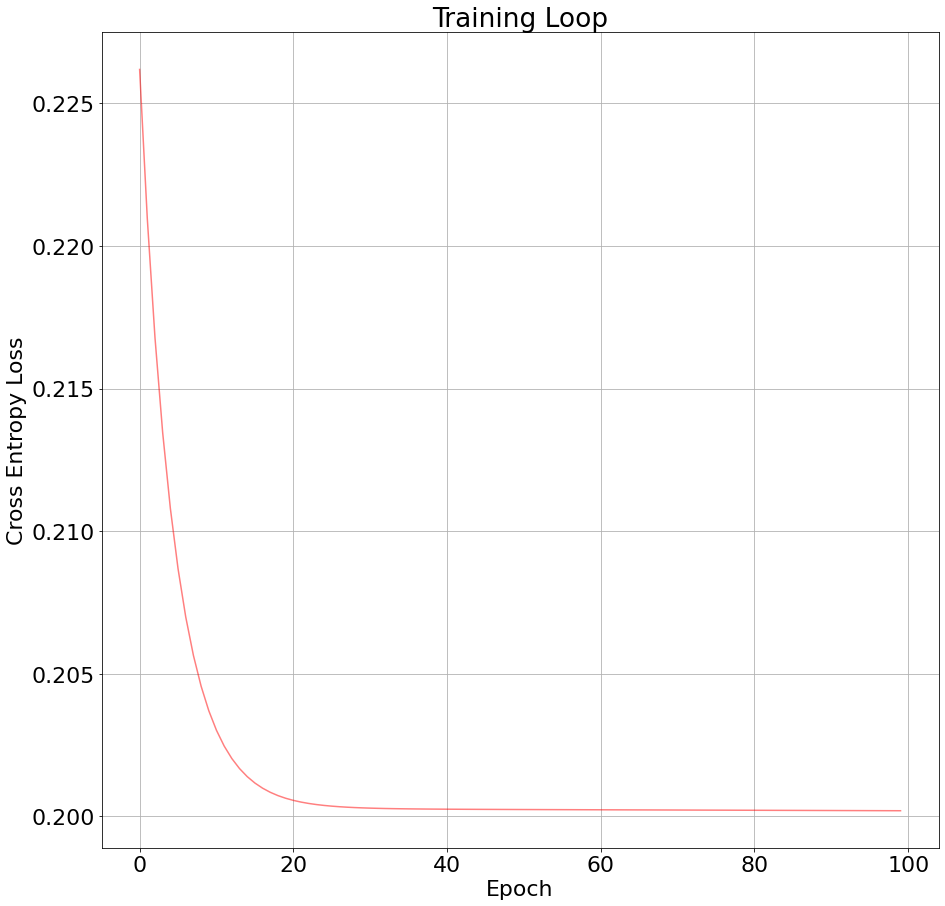

In [11]:
def train(model, inputs, targets, num_epochs, lr):

    # Entropia cruzada
    loss_func = nn.BCEWithLogitsLoss()
    # Otimizador. SGD significa Stochastic Gradient Descent. O construtor recebe 
    # como entrada os parâmetros do modelo e a tplta de aprendizado
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    losses = []
    for epoch in range(0, num_epochs):
        # Apaga os gradientes
        optim.zero_grad()
        scores = model(inputs)
        loss = loss_func(scores, targets)
        # Calcula os gradientes
        loss.backward()
        # Atualiza os gradientes
        optim.step()
        losses.append(loss.item())

    return losses

with torch.no_grad():
    # [:] indica uma modificação inplace. Equivalente a
    # model.weight.fill_(19.)
    model.weight[:] = 19.
    model.bias[:] = -25.

losses = train(model, inputs, targets, num_epochs=100, lr=0.5)

plt.rcParams.update({'font.size': 22})  
plt.figure(figsize=(15,15))
plt.plot(losses, linestyle='-', color='red', alpha=0.5)  
plt.title(f'Training Loop')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.grid(True)

plt.show()